In [1]:
import pandas as pd

In [2]:
Trump = pd.read_csv(r"C:\users\kevin\Trump.csv")
Trump.head()

,Unnamed: 0,id,created_time,text,source,favorite_count,retweet_count,username
0,0,836933725602656256,2017-03-01 13:38:44,THANK YOU!,Twitter for Android,133931,21289,realDonaldTrump
1,1,836753422271582208,2017-03-01 01:42:16,#JointSession #MAGA🇺🇸\r\nhttps://t.co/RDO6Jt...,Twitter for iPhone,48608,8527,realDonaldTrump
2,2,836750538943377408,2017-03-01 01:30:49,Join me live at 9:00 P.M. \r\n#JointAddress ht...,Twitter for iPhone,44261,6417,realDonaldTrump
3,3,836406328369242113,2017-02-28 02:43:03,I will be interviewed on @foxandfriends at 6:0...,Twitter for Android,75586,10582,realDonaldTrump
4,4,836332166728527872,2017-02-27 21:48:21,"GOP now viewed more favorably than Dems, in Tr...",Twitter for iPhone,64138,13731,realDonaldTrump


In [3]:
import nltk
from nltk.corpus import sentiwordnet as swn

def sentiment_of_word(s):
    '''
    Based on corpus "sentiwordnet", get the positive-negative score of a word.
    Input: s(string): a word for judgment.
    Output: score(float): the positive-negative score of the word.
    '''
    l = list(swn.senti_synsets(s))
    score = 0
    if len(l) > 0:
        for item in l:
            score += item.pos_score()
            score -= item.neg_score()
        score = score/len(l)
    return score

In [4]:
from nltk.corpus import stopwords

def sentiment_of_tweet(d):
    '''
    Based on sentiment_of_word, get the average score of a sentence or a paragraph (after removing stopwords).
    Input: d(string): a sentence or a paragraph.
    Output: average positive-negative score.
    '''
    stop = set(stopwords.words("english"))
    words = [word for word in d.lower().split() if word not in stop]
    score = 0
    for word in words:
        try:
            score += sentiment_of_word(word)
        except:
            pass
    return(score/len(words))

In [5]:
Trump["sentiment"] = [sentiment_of_tweet(text) for text in Trump["text"]]
Trump["negative"] = Trump["sentiment"]<0

In [6]:
Source_sentiment = pd.crosstab(index=Trump["negative"], columns=Trump["source"], margins = True)
Source_sentiment.index= ["positive","negative","All"]
Source_sentiment

source,Instagram,Media Studio,Periscope,Twitter Ads,Twitter Web Client,Twitter for Android,Twitter for iPad,Twitter for iPhone,All
positive,2,1,1,1,147,864,18,1090,2124
negative,0,0,0,0,126,604,4,387,1121
All,2,1,1,1,273,1468,22,1477,3245


In [7]:
#Chi_square test for Android and iPhone
import numpy as np
from scipy.stats import chisquare
obs = np.array([[Trump[(Trump["sentiment"]<0) & (Trump["source"] == "Twitter for Android")].shape[0],
                 Trump[(Trump["sentiment"]>=0) & (Trump["source"] == "Twitter for Android")].shape[0]],
                [Trump[(Trump["sentiment"]<0) & (Trump["source"] == "Twitter for iPhone")].shape[0],
                 Trump[(Trump["sentiment"]>=0) & (Trump["source"] == "Twitter for iPhone")].shape[0]]])
chisquare(obs,axis=None)

Power_divergenceResult(statistic=381.56162988115454, pvalue=2.1817299277856834e-82)

<p>We use Obama's tweets for comparison.</p>

In [8]:
Obama = pd.read_csv(r"C:\users\kevin\Obama.csv")
Obama.head()

,Unnamed: 0,id,created_time,text,source,favorite_count,retweet_count,username
0,0,832675462325243906,2017-02-17 19:37:55,We asked. You answered. https://t.co/mAJvko6VqR,Twitter Web Client,101664,23627,BarackObama
1,1,831527113211645959,2017-02-14 15:34:47,"Happy Valentine’s Day, @michelleobama! Almost ...",Twitter Web Client,1057719,255894,BarackObama
2,2,823230505546117120,2017-01-22 18:07:02,I read letters like these every single day. It...,Twitter Web Client,232803,35037,BarackObama
3,3,822553543479541761,2017-01-20 21:17:01,RT @ObamaFoundation: Add your voice: https://t...,Twitter Web Client,0,48010,BarackObama
4,4,822550536469803009,2017-01-20 21:05:04,"In the meantime, I want to hear what you're th...",Twitter Web Client,236278,54259,BarackObama


In [9]:
Obama["sentiment"] = [sentiment_of_tweet(text) for text in Obama["text"]]
Obama["negative"] = Obama["sentiment"]<0
Obama.groupby(by="negative").count()["id"]

negative
False    2415
True      810
Name: id, dtype: int64

<p>For Obama, the proportion of negative tweets is about 25.1%. It is 26.2% for Trump's iPhone, and 41.1% for Trump's Android.</p>
<p>The proportion of Trump's iPhone is close to Obama's. However, Trump's Android is extremely high.</p>

<p>Also, for Trump, we want to see whether his tweets' ratio of negative change over times.</p>

In [10]:
import datetime
Trump["created_time"] = [datetime.datetime.strptime(Trump["created_time"].iloc[i],"%Y-%m-%d %H:%M:%S") for i in xrange(Trump.shape[0])]

Trump["year"] = [Trump["created_time"].iloc[i].year for i in xrange(Trump.shape[0])]
Trump["week"] = [Trump["created_time"].iloc[i].week for i in xrange(Trump.shape[0])]

In [11]:
def return_year(i):
    '''
    For 2017-01-01, the year is 2017 but the week is 52. That is because in system that day belongs to the last week in 2016.
    '''
    if Trump["created_time"].iloc[i].year == 2017 and Trump["created_time"].iloc[i].month == 1 and Trump["created_time"].iloc[i].day == 1:
        return 2016
    else:
        return Trump["created_time"].iloc[i].year
    
Trump["year"] = [return_year(i) for i in xrange(Trump.shape[0])]

In [12]:
Trump_week = Trump.groupby(by=["year","week","source"]).count().reset_index()[["year","week","id","source"]].merge(Trump.groupby(by=["year","week","source"]).sum().reset_index()[["year","week","negative","source"]],on=["year","week","source"])
Trump_week.head()

,year,week,id,source,negative
0,2016,11,23,Twitter for Android,10.0
1,2016,11,11,Twitter for iPhone,1.0
2,2016,12,7,Twitter Web Client,4.0
3,2016,12,57,Twitter for Android,22.0
4,2016,12,12,Twitter for iPhone,2.0


In [13]:
Trump_week_total = Trump_week.groupby(by=["year","week"]).sum()
Trump_week_total = Trump_week_total.reset_index()
Trump_week_total.shape

(51, 4)

In [14]:
Trump_week_android = Trump_week[Trump_week["source"] == "Twitter for Android"]
Trump_week_android.shape

(51, 5)

In [15]:
Trump_week_iphone = Trump_week[Trump_week["source"] == "Twitter for iPhone"]
Trump_week_iphone = pd.concat([Trump_week_iphone.iloc[0:35],pd.DataFrame({"year":2016,"week":46,"id":0,"source":"Twitter for iPhone","negative":0},index=[20]),Trump_week_iphone.iloc[35:]])
Trump_week_iphone.shape

(51, 5)

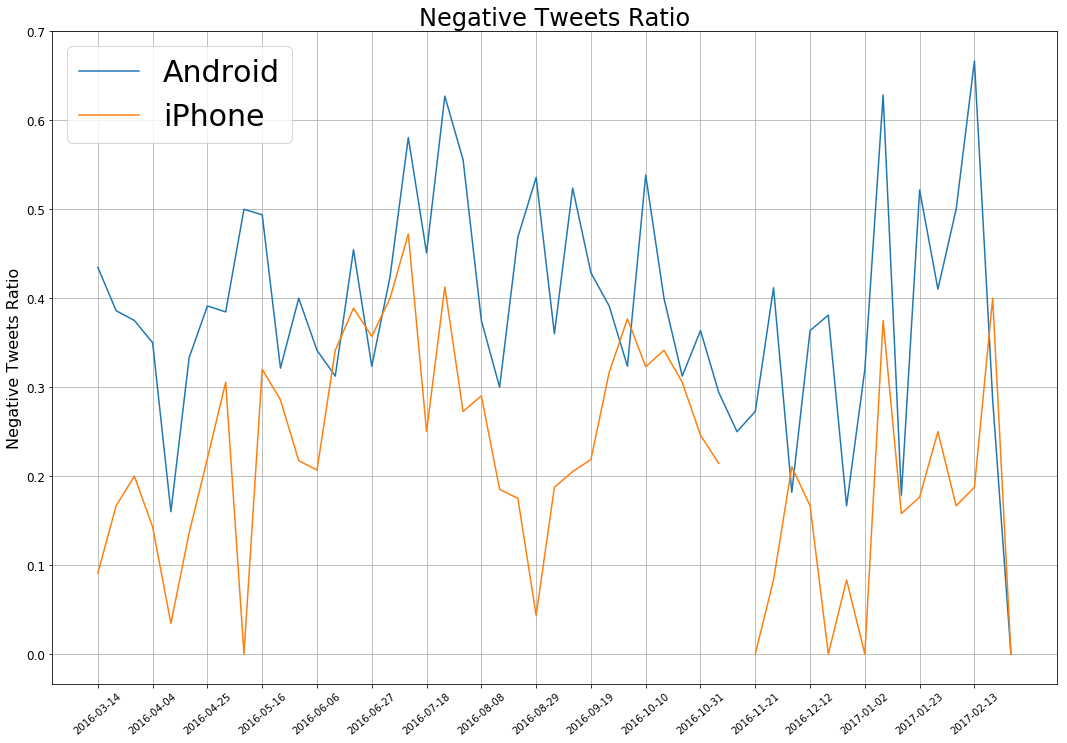

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
plt.rcParams['ytick.labelsize'] = 12
fig,ax = plt.subplots()

xticks = range(0,Trump_week_android.shape[0],3)
labels = [datetime.datetime.strptime("{} {} 1".format(Trump_week_total["year"].iloc[i], Trump_week_total["week"].iloc[i]), '%Y %W %w').date() for i in xrange(Trump_week_total.shape[0])]
xlabels = [labels[index] for index in xticks]

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,rotation=40)

#week_total = list(Trump_week_total["negative"]/Trump_week_total["id"], label = "total)
week_android = list(Trump_week_android["negative"]/Trump_week_android["id"])
week_iphone = list(Trump_week_iphone["negative"]/Trump_week_iphone["id"])

#plt.plot(week_total)
plt.plot(week_android,label = "Android")
plt.plot(week_iphone, label = "iPhone")
plt.grid()
plt.legend(loc=2, prop={"size":30})
plt.title('Negative Tweets Ratio',size=24)
plt.ylabel("Negative Tweets Ratio",size=16)
plt.show()

<p>2016-07-02: Hillary Clinton's corruption scandal
<p>2016-09-09: Hillary's "Basket Of Deplorables"
<p>2016-10-07: Sexual misconduct accusations
<p>2017-01-09: Meryl Streep's speech
<p>2017-01-20: Inauguration
<p>2017-02-13: Michael Flynn resigned.